# Cluster Mean Plotting

#### If you only want to see the graphs, you can skip down to the interactive portion!

In [1]:
%%html
<script>
    // AUTORUN ALL CELLS ON NOTEBOOK-LOAD!
    require(
        ['base/js/namespace', 'jquery'], 
        function(jupyter, $) {
            $(jupyter.events).on("kernel_ready.Kernel", function () {
                console.log("Auto-running all cells-below...");
                jupyter.actions.call('jupyter-notebook:run-all-cells-below');
                jupyter.actions.call('jupyter-notebook:save-notebook');
            });
        }
    );
</script>

In [1]:
import seaborn as sn
import numpy as np
%matplotlib inline

In [2]:
def upcase_first_letter(s):
    return s[0].upper() + s[1:]
def title(string):
    return ' '.join([upcase_first_letter(s) for s in string.split(' ')])

In [3]:
def cust_factorplot(x, y, hue, data, kind, palette, ax=None):
    sn.factorplot(x=x,y=y,hue=hue,data=data, kind=kind, palette=palette, ax=ax)
    sn.plt.close()
    ax.set_axis_bgcolor('white')
    ax.spines['bottom'].set_color('black')
    ax.set_xlabel("")
    ax.set_ylabel("weight")

In [204]:
def img_plot(c):
    img_fig, axs = sn.plt.subplots(1,3,figsize=[15,45])
    slices = [slice(None,None,None)]*3
    for i, ax in enumerate(axs):
        indices = sorted(set([0,1,2]) - set([i]))
        cur_slices = slices[:]
        cur_slices[i] = c[i] 
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(np.swapaxes(MNI[cur_slices], 1, 0), cmap='gray',)
        ax.imshow(np.swapaxes(masked_inter[cur_slices], 1, 0), cmap='coolwarm', vmax=3, vmin=-3)
        ax.axvline(color='g', x=c[indices[0]])
        ax.axhline(color='g', y=c[indices[1]])

In [174]:
def plot_cluster(cluster_name, which):
    entry = means_dict[cluster_name]
    vel_df = entry['vel_df']
    prox_df = vel_df = entry['prox_df']
    num = int(entry['number']) - 1
    x, y, z = (int(xcoords[num]), int(ycoords[num]), int(zcoords[num]))
    print(x, y ,z)
    img_plot([x, y, z])
    if which == 'velocity':
        fig, ax = sn.plt.subplots(1, figsize=(6,4))
        cust_factorplot(x='prox',y='weight',hue='vel',data=vel_df, kind='bar', palette=np.array(sn.color_palette())[[0,2]], ax=ax)
        ax.set_title('{}:\nVelocity Binned by Proximity'.format(title(cluster_name.replace('_', ' '))), ha='center')
    elif which == 'proximity':
        fig, ax = sn.plt.subplots(1, figsize=(6,4))
        cust_factorplot(x='vel',y='weight',hue='prox',data=prox_df, kind='bar', palette=np.array(sn.color_palette())[[1,3]], ax=ax)
        ax.set_title('{}:\nProximity Binned by Velocity'.format(title(cluster_name.replace('_', ' '))), ha='center')
    else:
        fig, (vel_ax, prox_ax) = sn.plt.subplots(1, 2, figsize=(12,4))
        cust_factorplot(x='prox',y='weight',hue='vel',data=vel_df, kind='bar', palette=np.array(sn.color_palette())[[0,2]], ax=vel_ax)
        vel_ax.set_title('{}:\nVelocity Binned by Proximity'.format(title(cluster_name.replace('_', ' '))), ha='center')
        cust_factorplot(x='vel',y='weight',hue='prox',data=prox_df, kind='bar', palette=np.array(sn.color_palette())[[1,3]], ax=prox_ax)
        prox_ax.set_title('{}:\nProximity Binned by Velocity'.format(title(cluster_name.replace('_', ' '))), ha='center')

In [5]:
import os
import pandas as pd

In [161]:
clust_files = [x for x in os.listdir() if x.endswith('.1D')]
clust_nums = [x.split('_')[1] for x  in clust_files]
clust_df = pd.DataFrame([clust_nums,clust_files]).T
clust_df.columns = ['number', 'mean_file']
clust_df = clust_df.sort_values(by='number')
clust_df.index = ['right_latIPS', 'left_latIPS',
                  'left_FEF', 'right_FEF',
                  'left_SMA', 'right_insula',
                  'right_SMA', 'right_caudate',
                  'right_PAG', 'right_amygdala',
                  'left_insula', 'MPFC', 
                  'left_PAG','left_caudate']
clust_df = clust_df.ix[['right_latIPS', 'left_latIPS',
                  'left_FEF', 'right_FEF',
                  'left_SMA', 'right_SMA',
                  'right_insula', 'left_insula',
                  'right_caudate', 'left_caudate',
                  'right_PAG', 'left_PAG',
                  'right_amygdala', 'MPFC'],:]
means_dict = {row[0]: {'vel_df':pd.DataFrame([-np.loadtxt(row[1].mean_file)[:,1],
                                              ['approach']*2 + ['retreat']*2,
                                              ['near', 'far', 'near', 'far']],
                                             index = ['weight', 'vel', 'prox']).T,
                       'prox_df':pd.DataFrame([-np.loadtxt(row[1].mean_file)[:,0],
                                              ['approach']*2 + ['retreat']*2,
                                              ['near', 'far', 'near', 'far']],
                                             index = ['weight', 'vel', 'prox']).T,
                       'number':row[1]['number']
                       } for row in clust_df.iterrows()
                      }

In [30]:
from nibabel import load

In [180]:
coords = pd.read_csv('./velxprox_coords', delim_whitespace=True, header=None)
ycoords = coords[14].astype(int)/2 + 45
xcoords = -coords[13].astype(int)/2 + 45
zcoords = MNI.shape[2] - (coords[15].astype(int)/2 + 36)
MNI = load('./MNI152_T1_2mm.nii.gz').get_data()[::-1,::-1,::-1]
inter = load('./VelocityXProximity_v_Background.nii.gz').get_data()[::-1,::-1,::-1,0,1]
masked_inter = np.ma.masked_where(abs(inter) < 3 , inter)

In [7]:
from ipywidgets import interact, widgets
from IPython.display import display

## Interactive Graphing Portion

33 52 27


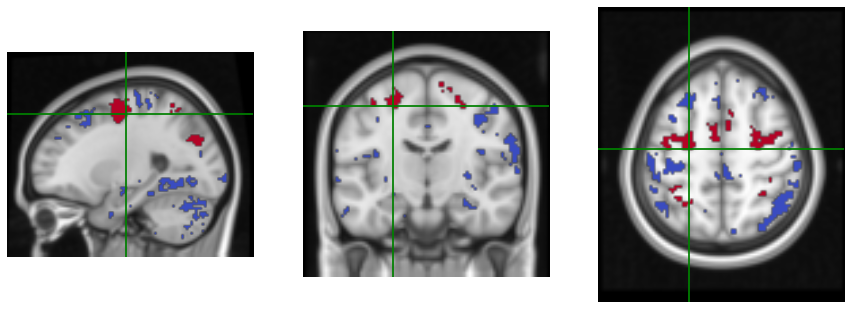

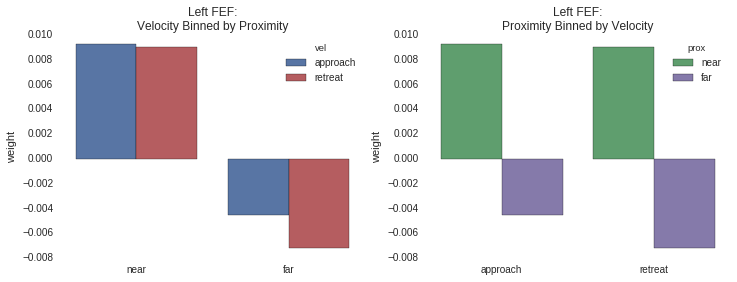

In [205]:
i = interact(plot_cluster,
             cluster_name=widgets.Select(options=clust_df.index.values.tolist(), 
                                         value='right_latIPS',
                                         description='Choose Region'),
             which=widgets.RadioButtons(options=['both', 'velocity', 'proximity'],
                                        value='both',
                                        description='Which Graphs?')
            )